In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

import re
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [ ]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_validate

In [ ]:
random_seed = 99

# Load data

In [203]:
df_train = pd.read_csv("../data/titanic/train.csv")
df_test = pd.read_csv("../data/titanic/test.csv")
print(df_train.shape)
print(df_test.shape)

(891, 12)
(418, 11)


# Preprocessing

In [204]:
# get deck letter from cabin
df_train['cabin_deck'] = df_train['Cabin'].str.extract(r'([a-z]+\d+)', re.IGNORECASE)
df_train['cabin_deck'] = df_train['cabin_deck'].str.replace(r'\d+', '', regex=True)

df_test['cabin_deck'] = df_test['Cabin'].str.extract(r'([a-z]+\d+)', re.IGNORECASE)
df_test['cabin_deck'] = df_test['cabin_deck'].str.replace(r'\d+', '', regex=True)

# EDA

In [184]:
target_col = 'Survived'
cat_features = ['Sex', 'Embarked', 'cabin_deck'] # cabin / deck?
num_features = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [185]:
# data types
df_train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
cabin_deck      object
dtype: object

In [146]:
df_train.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Long, Mr. Milton Clyde",male,NaN,NaN,NaN,1601,NaN,C23 C25 C27,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [ ]:
# target distribution 
print(df_train[target_col].value_counts())
print(df_train[target_col].value_counts('pct'))

In [ ]:
# missing values- Age, Cabin, Embarked
df_train.isna().sum()

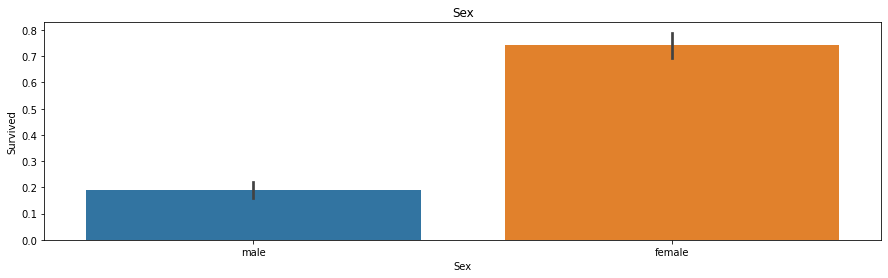

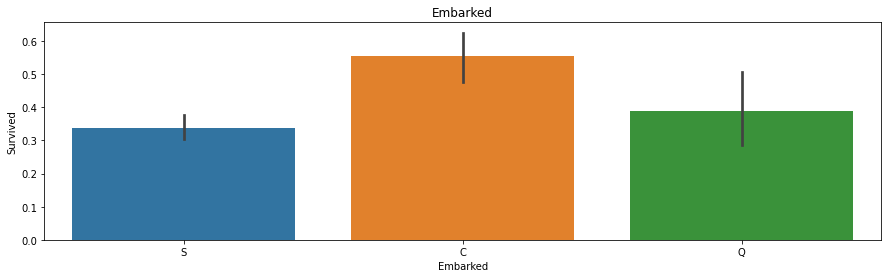

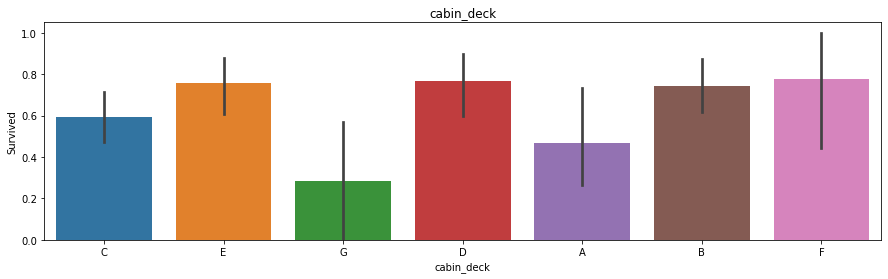

In [186]:
# categorical - binary target distribution
for feat in cat_features:
    plt.figure(figsize=(15, 4))
    sns.barplot(x=feat, y=target_col, data=df_train, estimator=np.mean).set(title=feat);

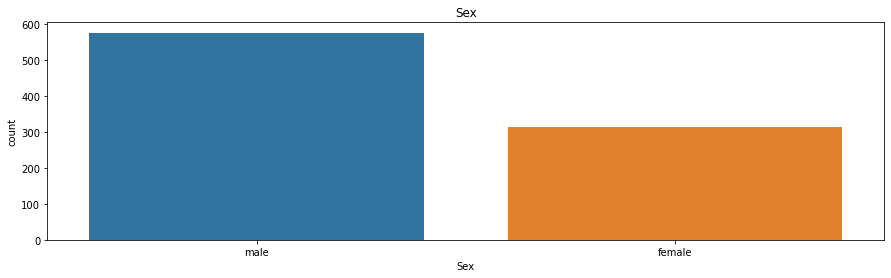

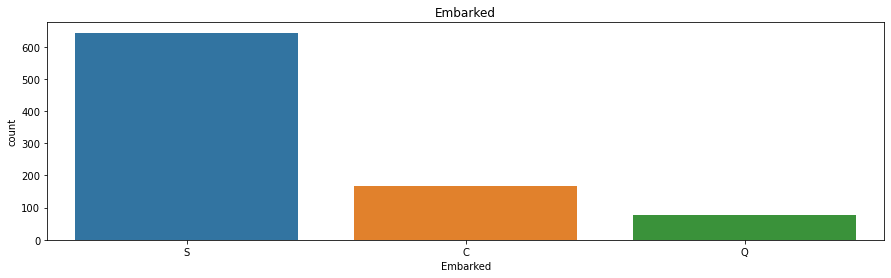

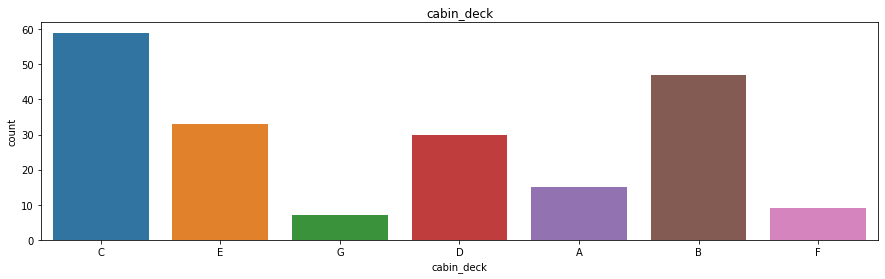

In [187]:
# categorical - volume
for feat in cat_features:
    plt.figure(figsize=(15, 4))
    sns.countplot(x=feat, data=df_train).set(title=feat);

In [ ]:
# # numeric - distrbition by target variable
# for feat in num_features:
#     plt.figure(figsize=(15,4))
#     sns.boxplot(data=df_train, x=target_col, y=feat).set(title=feat);

# with subplots
plt.figure(figsize=(15, 15))
for i, feat in enumerate(num_features):
    ax = plt.subplot(3,2, i+1)
    sns.boxplot(data=df_train, x=target_col, y=feat).set(title=feat);

In [ ]:
# feature distribution
# Pair plots coluoured by target
plt.figure(figsize=(20,20))
sns.pairplot(df_train, hue=target_col, vars=df_train.select_dtypes(include=['float64', 'int64', 'int32']).columns);

In [ ]:
# Plot correlations between features (numeric)
correlation_matrix = df_train[num_features + [target_col]].corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True) # annot = True to print the values inside the square

# Prepare Features

In [206]:
X = df_train[num_features + cat_features].copy()
y = df_train[target_col].copy()

X_test = df_test[num_features + cat_features].copy()

In [189]:
# split into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=random_seed, stratify=y)
print(X_train.shape,
      y_train.shape,
      X_val.shape,
      y_val.shape)

(623, 8) (623,) (268, 8) (268,)


# Fit model training pipeline

### Train / val

In [190]:
# Preprocessor transforms
# fill age with Median values, Embarked/cabin with 'missing'
num_transforms  = Pipeline([
    ('impute_median', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler() )])

cat_transforms = Pipeline([
    ('impute_missing', SimpleImputer(strategy="constant", fill_value="missing")),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num_features', num_transforms, num_features),
    ('cat_features', cat_transforms, cat_features)
])

In [191]:
# Define model
rf = RandomForestClassifier(random_state=random_seed, n_jobs=-1)

In [192]:
# Define pipeline
pipe = Pipeline([
    ('prep', preprocessor),
    ('model', rf)
])

In [193]:
# Fit pipeline
pipe.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num_features',
                                                  Pipeline(steps=[('impute_median',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Pclass', 'Age', 'SibSp',
                                                   'Parch', 'Fare']),
                                                 ('cat_features',
                                                  Pipeline(steps=[('impute_missing',
                                                                   SimpleImputer(fill_value='missing',
                                                                                 strategy='constant')),
                                                     

# Evaluate

In [194]:
preds = pipe.predict(X_val)
pred_prob = pipe.predict_proba(X_val)[:, 1]

In [195]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

           0       0.85      0.81      0.83       165
           1       0.71      0.78      0.74       103

    accuracy                           0.79       268
   macro avg       0.78      0.79      0.79       268
weighted avg       0.80      0.79      0.80       268



In [196]:
roc_auc_score(y_val, preds)

0.7913798175934098

### Cross val with Gridsearch

In [197]:
# Use StratifiedKFold for cross val
skfold = StratifiedKFold(n_splits = 3, shuffle=True, random_state=random_seed)

# Define parameter grid
params = {
    "model__n_estimators": [100, 200],
    "model__min_samples_leaf": [1, 2, 4],
    "model__min_samples_split": [2, 5, 10], 
    "model__class_weight": ["balanced", "balanced_subsample", None]
}

# Define pipeline
pipe_gs = Pipeline([
    ('prep', preprocessor),
    ('model', rf)
])

# Define Gridsearch
gs = GridSearchCV(pipe_gs,
                    params,
                    cv=skfold,
                    scoring='roc_auc',
                    n_jobs=-1,
                    verbose=4)

# Perform GS
gs.fit(X_train, y_train)


Fitting 3 folds for each of 54 candidates, totalling 162 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=99, shuffle=True),
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('num_features',
                                                                         Pipeline(steps=[('impute_median',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Pclass',
                                                                          'Age',
                                                                          'SibSp',
                                                                          'Parch',
             

In [198]:
# Evaluate best estimator
print(gs.best_params_)

pred_proba_val = gs.best_estimator_.predict_proba(X_val)[:, 1]
pred_val = gs.best_estimator_.predict(X_val)
print(roc_auc_score(y_val, pred_proba_val))

print(classification_report(y_val, pred_val))

{'model__class_weight': 'balanced_subsample', 'model__min_samples_leaf': 1, 'model__min_samples_split': 10, 'model__n_estimators': 200}
0.8619005589879377
              precision    recall  f1-score   support

           0       0.88      0.81      0.84       165
           1       0.73      0.83      0.77       103

    accuracy                           0.81       268
   macro avg       0.80      0.82      0.81       268
weighted avg       0.82      0.81      0.82       268



In [199]:
# pd.DataFrame(gs.cv_results_)

### Vanilla cross val

In [200]:
# Use StratifiedKFold for cross val
skfold = StratifiedKFold(n_splits = 3, shuffle=True, random_state=random_seed)

# Define pipeline
pipe_cv = Pipeline([
    ('prep', preprocessor),
    ('model', rf)
])

In [201]:
# Run CV
metrics = cross_validate(pipe_cv, X, y, cv=skfold, scoring="roc_auc", return_estimator=True)
print(metrics['test_score'])
print(np.mean(metrics['test_score']))

[0.82281181 0.87642604 0.82827629]
0.8425047135142044


In [207]:
preds_test = metrics['estimator'][0].predict(X_test)